In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
import io


In [2]:
import geopandas as gpd
import cudf

# Load the GeoPackage
gdf = gpd.read_file(r'/mnt/c/Users/Ruben/Documents/Project_crime/data/crime_data_London.gpkg',
                    engine='pyogrio',
                    use_arrow = True)

# Extract coordinates and create a cuDF DataFrame
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
cudf_df = cudf.DataFrame.from_pandas(gdf[['x', 'y']])


In [53]:
gdf.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry,x,y
0,None,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Barking and Dagenham 010B,Anti-social behaviour,None,None,POINT (0.16578 51.5442),0.165776,51.5442
1,None,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Barking and Dagenham 010B,Anti-social behaviour,None,None,POINT (0.16578 51.5442),0.165776,51.5442
2,None,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Barking and Dagenham 010B,Violent crime,None,None,POINT (0.16578 51.5442),0.165776,51.5442
3,None,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Barking and Dagenham 010B,Violent crime,None,None,POINT (0.16578 51.5442),0.165776,51.5442
4,None,2010-12,British Transport Police,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Barking and Dagenham 010B,Violent crime,None,None,POINT (0.16578 51.5442),0.165776,51.5442


In [3]:
cudf_df

,x,y
0,0.165776,51.544200
1,0.165776,51.544200
2,0.165776,51.544200
3,0.165776,51.544200
4,0.165776,51.544200
...,...,...
15452749,-0.116921,51.382407
15452750,-0.101292,51.514770
15452751,-0.084344,51.316259
15452752,-0.084344,51.316259


In [ ]:

# Define the canvas resolution and spatial extents based on your data
x_min = cudf_df['x'].min().item()
x_max = cudf_df['x'].max().item()
y_min = cudf_df['y'].min().item()
y_max = cudf_df['y'].max().item()

canvas = ds.Canvas(plot_width=1920, plot_height=1080,
                   x_range=(x_min, x_max),
                   y_range=(y_min, y_max))


# Aggregate the points (this step is GPU-accelerated with cuDF)
agg = canvas.points(cudf_df, 'x', 'y')

# Shade the aggregated image with a color map, then optionally spread to improve point visibility
img = tf.shade(agg, cmap=["red", "yellow"], how='log')
img = tf.dynspread(img, threshold=0.5, max_px=2)

# Save the final image
img.to_pil().save("crime_vertices.png")


In [ ]:

# === Step 1: Generate Datashader Image for Points ===
# Determine spatial extents from your cuDF DataFrame
x_min = cudf_df['x'].min().item()
x_max = cudf_df['x'].max().item()
y_min = cudf_df['y'].min().item()
y_max = cudf_df['y'].max().item()

# Create a 1920x1080 canvas
canvas = ds.Canvas(
    plot_width=1920,
    plot_height=1080,
    x_range=(x_min, x_max),
    y_range=(y_min, y_max)
)

# Aggregate the points (GPU-accelerated with cuDF)
agg = canvas.points(cudf_df, 'x', 'y')

# Shade using a log transform and dynamic spreading
img = tf.shade(agg, cmap=["red", "yellow"], how='log')
img = tf.dynspread(img, threshold=0.5, max_px=2)
ds_pil = img.to_pil()

# === Step 2: Render the Borough Polygons with Transparent Fill, White Lines & Labels ===
# Load borough polygons and reproject to EPSG:4326 (assuming points use this CRS)
boroughs = gpd.read_file(
    r'/mnt/c/Users/Ruben/Documents/Project_crime/data/London_Boroughs.gpkg',
    layer='london_boroughs'
)
boroughs = boroughs.to_crs(epsg=4326)

# Create a matplotlib figure with the same resolution as the datashader image
fig, ax = plt.subplots(figsize=(1920/100, 1080/100), dpi=100)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis('off')  # Remove axes for a clean map

# Plot polygons with no fill (transparent) and white outlines
boroughs.plot(
    ax=ax,
    facecolor="none",      # transparent fill
    edgecolor="white",     # white borders
    linewidth=0.9,
    alpha=0.4
)



# Save the polygon (with labels) layer to an in-memory buffer
buf = io.BytesIO()
plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, transparent=True)
plt.close(fig)
buf.seek(0)
polygon_img = Image.open(buf)
polygon_img = polygon_img.resize(ds_pil.size)

# === Step 3: Composite the Two Layers ===
# Overlay the polygon layer (with labels and white boundaries) on top of the datashader image
composite = Image.alpha_composite(ds_pil.convert("RGBA"), polygon_img.convert("RGBA"))
composite.save("crime_vertices.png")


In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load borough polygons and reproject to EPSG:4326
boroughs = gpd.read_file(
    r'/mnt/c/Users/Ruben/Documents/Project_crime/data/London_Boroughs.gpkg',
    layer='london_boroughs'
)
boroughs = boroughs.to_crs(epsg=4326)

# Determine spatial extent of the polygons
poly_minx, poly_miny, poly_maxx, poly_maxy = boroughs.total_bounds

# Create a figure sized for 1920x1080 (16:9)
fig, ax = plt.subplots(figsize=(1920/100, 1080/100), dpi=100)
ax.set_xlim(poly_minx, poly_maxx)
ax.set_ylim(poly_miny, poly_maxy)
ax.set_aspect('equal')
ax.axis('off')  # Remove axes for a clean map

# Plot boroughs with a slightly grey fill and white outlines
boroughs.plot(
    ax=ax,
    facecolor="#555555",  # slightly grey fill
    edgecolor="white",    # white boundaries
    linewidth=1.0,
    alpha=0.9             # nearly opaque fill
)

# Calculate centroids for label placement
boroughs["centroid"] = boroughs.geometry.centroid

# Add labels for each polygon using the 'name' column
for idx, row in boroughs.iterrows():
    cx, cy = row["centroid"].x, row["centroid"].y
    label = row["name"]
    ax.text(
        cx, cy, label,
        fontsize=10, color="white",
        ha="center", va="center", wrap=True
    )

# Adjust the subplot to use the full figure area
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the figure with a black background so it fits perfectly on a slide
plt.savefig(
    "boroughs_labeled_only_1920x1080.png",
    dpi=100,
    facecolor="black"  # sets the figure background to black
)
plt.close(fig)


/tmp/ipykernel_20626/247484634.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  boroughs["centroid"] = boroughs.geometry.centroid


# gif

In [ ]:
import datashader as ds
import datashader.transfer_functions as tf
import geopandas as gpd
import cudf
import imageio
from PIL import Image, ImageDraw, ImageFont
import io


# Extract x, y coordinates
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# (Optional) Format 'Month' as string "YYYY-MM" if needed:
# gdf['Month'] = gdf['Month'].dt.strftime('%Y-%m')

# Create a cuDF DataFrame from the pandas GeoDataFrame
cudf_df_all = cudf.DataFrame.from_pandas(gdf[['x', 'y', 'Month']])

# Determine overall spatial extent to keep the canvas consistent
x_min = cudf_df_all['x'].min().item()
x_max = cudf_df_all['x'].max().item()
y_min = cudf_df_all['y'].min().item()
y_max = cudf_df_all['y'].max().item()

# Get a sorted list of unique months (as strings)
months = sorted(cudf_df_all['Month'].unique().to_pandas().tolist())

# --- Generate Frames ---
frames = []
plot_width, plot_height = 1920, 1080  # Resolution

for m in months:  # Assuming 'months' is defined elsewhere
    month_df = cudf_df_all[cudf_df_all['Month'] == m]  # Assuming 'cudf_df_all' is a CuDF DataFrame
    
    # Datashader canvas and aggregation
    canvas = ds.Canvas(
        plot_width=plot_width, plot_height=plot_height,
        x_range=(x_min, x_max), y_range=(y_min, y_max)  # Assuming ranges are defined
    )
    agg = canvas.points(month_df, 'x', 'y')
    img = tf.shade(agg, cmap=["red", "yellow"])#, how='log')
    img = tf.dynspread(img, threshold=0.5, max_px=2)
    
    # Convert to PIL and composite with black background
    ds_pil = img.to_pil()
    background = Image.new("RGBA", (plot_width, plot_height), "black")
    combined = Image.alpha_composite(background, ds_pil.convert("RGBA"))
    draw = ImageDraw.Draw(combined)

    # --- Font Configuration ---
    try:
        title_font = ImageFont.truetype("arial.TTF", 40)  # Improved size
        month_font = ImageFont.truetype("arial.TTF", 50)  # Improved size
        label_font = ImageFont.truetype("arial.TTF", 30)   # Improved size
    except IOError:
        try:
            title_font = ImageFont.truetype("DejaVuSans-Bold", 30)
            month_font = ImageFont.truetype("DejaVuSans-Bold", 50)
            label_font = ImageFont.truetype("DejaVuSans-Bold", 20)
        except IOError:
            title_font = month_font = label_font = ImageFont.load_default()

    # --- Title with Background ---
    title_text = "Crime Data in London, all crime reported on the street, Dec 2013 - Jan 2025"
    title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
    title_width = title_bbox[2] - title_bbox[0]
    title_height = title_bbox[3] - title_bbox[1]
    title_left = (plot_width - title_width) // 2
    title_top = 30
    draw.rectangle([title_left, title_top, title_left + title_width, title_top + title_height], fill="black")
    draw.text((title_left, title_top), title_text, fill="white", font=title_font, 
              stroke_width=4, stroke_fill="black")

    # --- Month Label with Background ---
    month_text = m
    month_bbox = draw.textbbox((0, 0), month_text, font=month_font)
    month_width = month_bbox[2] - month_bbox[0]
    month_height = month_bbox[3] - month_bbox[1]
    month_left = plot_width - month_width - 100
    month_top = plot_height - 160  # Adjusted for larger font
    draw.rectangle([month_left, month_top, month_left + month_width, month_top + month_height], fill="black")
    draw.text((month_left, month_top), month_text, fill="white", font=month_font, 
              stroke_width=4, stroke_fill="black")

    # --- Colorbar ---
    bar_width, bar_height = 24, 400
    bar_margin = 30
    colorbar = Image.new("RGB", (bar_width, bar_height), "black")
    bar_draw = ImageDraw.Draw(colorbar)
    for i in range(bar_height):
        ratio = i / (bar_height - 1)
        r, g, b = 255, int(ratio * 255), 0
        bar_draw.line([(0, bar_height - 1 - i), (bar_width, bar_height - 1 - i)], fill=(r, g, b))
    combined.paste(colorbar, (plot_width - bar_width - bar_margin, 150))

    # --- Colorbar Labels with Background ---
    # High label
    high_text = "High"
    high_bbox = draw.textbbox((0, 0), high_text, font=label_font)
    high_width = high_bbox[2] - high_bbox[0]
    high_height = high_bbox[3] - high_bbox[1]
    high_left = plot_width - bar_width - bar_margin - high_width - 30
    high_top = 140
    draw.rectangle([high_left, high_top, high_left + high_width, high_top + high_height], fill="black")
    draw.text((high_left, high_top), high_text, fill="white", font=label_font, 
              stroke_width=4, stroke_fill="black")

    # Low label
    low_text = "Low"
    low_bbox = draw.textbbox((0, 0), low_text, font=label_font)
    low_width = low_bbox[2] - low_bbox[0]
    low_height = low_bbox[3] - low_bbox[1]
    low_left = plot_width - bar_width - bar_margin - low_width - 30
    low_top = 150 + bar_height - low_height
    draw.rectangle([low_left, low_top, low_left + low_width, low_top + low_height], fill="black")
    draw.text((low_left, low_top), low_text, fill="white", font=label_font, 
              stroke_width=4, stroke_fill="black")

    # --- North Arrow ---
    # Define arrow coordinates
    arrow_start = (80, 230)
    arrow_end = (80, 120)

    # Define arrowhead parameters
    arrowhead_height = 34
    arrowhead_base_y = arrow_end[1] + arrowhead_height  # 120 + 24 = 144
    shaft_end = (arrow_end[0], arrowhead_base_y)  # (80, 144)

    # Draw the shaft
    draw.line([arrow_start, shaft_end], fill="white", width=12)

    # Draw the arrowhead
    arrowhead = [
        (arrow_end[0] - 12, arrowhead_base_y),  # (80 - 12, 144) = (68, 144)
        (arrow_end[0] + 12, arrowhead_base_y),  # (80 + 12, 144) = (92, 144)
        arrow_end                               # (80, 120)
    ]
    draw.polygon(arrowhead, fill="white")

    # Draw "N" with background
    n_text = "N"
    n_font = ImageFont.truetype("DejaVuSans-Bold", 35)
    n_bbox = draw.textbbox((0, 0), n_text, font=n_font)
    n_width = n_bbox[2] - n_bbox[0]
    n_height = n_bbox[3] - n_bbox[1]
    n_left = arrow_end[0] - 15              # 80 - 35 = 45
    n_top = arrow_end[1] - 70               # 120 - 70 = 50

    # Draw black background rectangle for "N"
    draw.rectangle([n_left, n_top, n_left + n_width, n_top + n_height], fill="black")

    # Draw "N" text
    draw.text(
        (n_left, n_top),
        n_text,
        fill="white",
        font=n_font,
        stroke_width=4,
        stroke_fill="black"
    )

    frames.append(combined)

# --- Save GIF ---
gif_filename = "crime_points_evolution.gif"
imageio.mimsave(gif_filename, frames, duration=1)
print(f"Saved GIF as {gif_filename}")

Saved GIF as crime_points_evolution.gif


In [26]:
import datashader as ds
import datashader.transfer_functions as tf
import geopandas as gpd
import cudf
import imageio
from PIL import Image, ImageDraw, ImageFont
import io
import numpy as np

# Load your GeoDataFrame (assuming 'gdf' is already loaded with 'geometry', 'Month', 'Crime type')
# Extract x, y coordinates
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# Ensure 'Crime type' is included in the cuDF DataFrame
cudf_df_all = cudf.DataFrame.from_pandas(gdf[['x', 'y', 'Month', 'Crime type']])

# Determine overall spatial extent for consistency across all GIFs
x_min = cudf_df_all['x'].min().item()
x_max = cudf_df_all['x'].max().item()
y_min = cudf_df_all['y'].min().item()
y_max = cudf_df_all['y'].max().item()

# Get sorted unique months
months = sorted(cudf_df_all['Month'].unique().to_pandas().tolist())

# Define canvas parameters
plot_width, plot_height = 1920, 1080
canvas = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=(x_min, x_max), y_range=(y_min, y_max))

# Font configuration (consistent across all GIFs)
try:
    title_font = ImageFont.truetype("arial.TTF", 40)
    month_font = ImageFont.truetype("arial.TTF", 50)
    label_font = ImageFont.truetype("arial.TTF", 30)
except IOError:
    try:
        title_font = ImageFont.truetype("DejaVuSans-Bold", 30)
        month_font = ImageFont.truetype("DejaVuSans-Bold", 50)
        label_font = ImageFont.truetype("DejaVuSans-Bold", 20)
    except IOError:
        title_font = month_font = label_font = ImageFont.load_default()

# --- 2. GIFs for Specific Crime Types ---

crime_types = ['Anti-social behaviour', 'Violent crime', 'Robbery', 'Burglary']

for crime_type in crime_types:
    # Filter data
    crime_df = cudf_df_all[cudf_df_all['Crime type'] == crime_type]
    if crime_df.empty:
        print(f"No data for crime type: {crime_type}, skipping GIF creation.")
        continue
    months_crime = sorted(crime_df['Month'].unique().to_pandas().tolist())
    
    # Generate frames
    frames_crime = []
    for m in months_crime:
        month_df = crime_df[crime_df['Month'] == m]
        agg = canvas.points(month_df, 'x', 'y')
        img = tf.shade(agg, cmap=["red", "yellow"])  # Log scale can be added with how='log' if needed
        img = tf.dynspread(img, threshold=0.5, max_px=2)
        
        # Convert to PIL
        ds_pil = img.to_pil()
        background = Image.new("RGBA", (plot_width, plot_height), "black")
        combined = Image.alpha_composite(background, ds_pil.convert("RGBA"))
        draw = ImageDraw.Draw(combined)
        
        # Title
        title_text = f"{crime_type} in London, Dec 2013 - Jan 2025"
        title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
        title_width = title_bbox[2] - title_bbox[0]
        title_height = title_bbox[3] - title_bbox[1]
        title_left = (plot_width - title_width) // 2
        title_top = 30
        draw.rectangle([title_left, title_top, title_left + title_width, title_top + title_height], fill="black")
        draw.text((title_left, title_top), title_text, fill="white", font=title_font, stroke_width=4, stroke_fill="black")
        
        # Month label
        month_text = m
        month_bbox = draw.textbbox((0, 0), month_text, font=month_font)
        month_width = month_bbox[2] - month_bbox[0]
        month_height = month_bbox[3] - month_bbox[1]
        month_left = plot_width - month_width - 100
        month_top = plot_height - 160
        draw.rectangle([month_left, month_top, month_left + month_width, month_top + month_height], fill="black")
        draw.text((month_left, month_top), month_text, fill="white", font=month_font, stroke_width=4, stroke_fill="black")
        
        # Colorbar
        bar_width, bar_height = 24, 400
        bar_margin = 30
        colorbar = Image.new("RGB", (bar_width, bar_height), "black")
        bar_draw = ImageDraw.Draw(colorbar)
        for i in range(bar_height):
            ratio = i / (bar_height - 1)
            r, g, b = 255, int(ratio * 255), 0
            bar_draw.line([(0, bar_height - 1 - i), (bar_width, bar_height - 1 - i)], fill=(r, g, b))
        combined.paste(colorbar, (plot_width - bar_width - bar_margin, 150))
        
        # Colorbar labels
        high_text = "High"
        high_bbox = draw.textbbox((0, 0), high_text, font=label_font)
        high_width = high_bbox[2] - high_bbox[0]
        high_height = high_bbox[3] - high_bbox[1]
        high_left = plot_width - bar_width - bar_margin - high_width - 30
        high_top = 140
        draw.rectangle([high_left, high_top, high_left + high_width, high_top + high_height], fill="black")
        draw.text((high_left, high_top), high_text, fill="white", font=label_font, stroke_width=4, stroke_fill="black")
        
        low_text = "Low"
        low_bbox = draw.textbbox((0, 0), low_text, font=label_font)
        low_width = low_bbox[2] - low_bbox[0]
        low_height = low_bbox[3] - low_bbox[1]
        low_left = plot_width - bar_width - bar_margin - low_width - 30
        low_top = 150 + bar_height - low_height
        draw.rectangle([low_left, low_top, low_left + low_width, low_top + low_height], fill="black")
        draw.text((low_left, low_top), low_text, fill="white", font=label_font, stroke_width=4, stroke_fill="black")
        
        # North Arrow
        arrow_start = (80, 230)
        arrow_end = (80, 120)
        arrowhead_height = 34
        arrowhead_base_y = arrow_end[1] + arrowhead_height
        shaft_end = (arrow_end[0], arrowhead_base_y)
        draw.line([arrow_start, shaft_end], fill="white", width=12)
        arrowhead = [
            (arrow_end[0] - 12, arrowhead_base_y),
            (arrow_end[0] + 12, arrowhead_base_y),
            arrow_end
        ]
        draw.polygon(arrowhead, fill="white")
        
        n_text = "N"
        n_font = ImageFont.truetype("DejaVuSans-Bold", 35)
        n_bbox = draw.textbbox((0, 0), n_text, font=n_font)
        n_width = n_bbox[2] - n_bbox[0]
        n_height = n_bbox[3] - n_bbox[1]
        n_left = arrow_end[0] - 15
        n_top = arrow_end[1] - 70
        draw.rectangle([n_left, n_top, n_left + n_width, n_top + n_height], fill="black")
        draw.text((n_left, n_top), n_text, fill="white", font=n_font, stroke_width=4, stroke_fill="black")
        
        # Append to the correct list
        frames_crime.append(combined)
    
    # Save GIF only if there are frames
    filename = f"{crime_type.replace(' ', '_').lower()}_evolution.gif"
    if frames_crime:
        imageio.mimsave(filename, frames_crime, duration=1)
        print(f"Saved GIF as {filename}")
    else:
        print(f"No frames for {crime_type}, skipping GIF creation.")

Saved GIF as anti-social_behaviour_evolution.gif
Saved GIF as violent_crime_evolution.gif
Saved GIF as robbery_evolution.gif
Saved GIF as burglary_evolution.gif


# Chloropleth gif

In [ ]:
import geopandas as gpd
import pandas as pd
import cudf
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw, ImageFont
import io

# ---------------------------
# 1. LOAD & PREPARE DATA
# ---------------------------

# 1.3. Spatial join - attach borough names to each crime record
joined = gpd.sjoin(
    gdf[['geometry', 'Month', 'Crime type']], 
    boroughs[['borough', 'geometry']],  # 'boroughs' should have a column named 'borough'
    how='left', 
    predicate='within'
)

# 1.4. Convert to cuDF for GPU-accelerated grouping
df = joined[['borough', 'Month', 'Crime type']].dropna(subset=['borough'])
cudf_df = cudf.DataFrame.from_pandas(df)
cudf_df['Month'] = pd.to_datetime(cudf_df['Month'].to_pandas())

# 1.5. Precompute aggregated counts (All Crime Types + Specific Types)
grouped_all = cudf_df.groupby(['borough', 'Month']).size().reset_index(name='average_crime_count_all')

crime_types = ['Anti-social behaviour', 'Violent crime', 'Robbery', 'Burglary']
grouped_by_type = {}
for ctype in crime_types:
    subset = cudf_df[cudf_df['Crime type'] == ctype]
    grouped = subset.groupby(['borough', 'Month']).size().reset_index(name='average_crime_count')
    grouped_by_type[ctype] = grouped

# Convert them back to pandas for easier merging/plotting
grouped_all_pd = grouped_all.to_pandas()
grouped_type_pd = {ctype: dfc.to_pandas() for ctype, dfc in grouped_by_type.items()}

# ---------------------------
# 2. SETUP FOR GIF CREATION
# ---------------------------

# 2.1. Unique months across the entire data
all_months = sorted(grouped_all_pd['Month'].unique())

# 2.2. Create a custom color map from red -> yellow (to match your DS colorbar)
red_to_yellow = mcolors.LinearSegmentedColormap.from_list(
    "red_to_yellow", [(1, 0, 0), (1, 1, 0)]
)

# 2.3. Font configuration
try:
    title_font = ImageFont.truetype("arial.TTF", 40)
    month_font = ImageFont.truetype("arial.TTF", 50)
    label_font = ImageFont.truetype("arial.TTF", 30)
except IOError:
    # Fallback(s)
    try:
        title_font = ImageFont.truetype("DejaVuSans-Bold", 30)
        month_font = ImageFont.truetype("DejaVuSans-Bold", 50)
        label_font = ImageFont.truetype("DejaVuSans-Bold", 20)
    except IOError:
        title_font = month_font = label_font = ImageFont.load_default()

# 2.4. For consistent layout, define canvas dimensions (similar to your DS approach)
plot_width, plot_height = 1920, 1080
DPI = 100  # so figure size in inches => (19.2, 10.8)

def global_vmin_vmax(count_df, colname='average_crime_count'):
    """Find global min and max for a column of aggregated crime counts."""
    vmin = count_df[colname].min()
    vmax = count_df[colname].max()
    return (vmin, vmax)

# ---------------------------
# 3. CHOROPLETH FRAME CREATION
# ---------------------------

def create_choropleth_frame(
    boroughs_gdf, 
    monthly_df, 
    month, 
    crime_label,
    vmin, 
    vmax, 
    title_text
):
    """
    Plot a single-month choropleth onto a Matplotlib figure sized 1920x1080,
    then composite with a black background. Lastly, annotate with text, arrow, etc.
    Returns a PIL Image object (RGBA).
    """
    # 3.1. Merge monthly data with borough polygons
    merged = boroughs_gdf.merge(monthly_df[monthly_df['Month'] == month],
                                on='borough', how='left')

    # 3.2. Create a figure exactly 1920×1080 in size
    fig, ax = plt.subplots(
        figsize=(plot_width / DPI, plot_height / DPI),
        dpi=DPI
    )
    # Remove margins so final PNG is 1920x1080 exactly
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.axis('off')
    
    # 3.3. Plot the polygons as a choropleth
    merged.plot(
        column='average_crime_count',
        ax=ax,
        cmap=red_to_yellow,
        edgecolor='black',
        linewidth=0.5,
        vmin=vmin,
        vmax=vmax
    )
    
    # 3.4. Render to PNG in memory (no 'tight' bounding box => exact 1920×1080)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    plt.close(fig)
    buf.seek(0)

    # 3.5. Open as PIL (RGBA)
    map_image = Image.open(buf).convert("RGBA")

    # 3.6. Composite onto black background (1920×1080)
    background = Image.new("RGBA", (plot_width, plot_height), "black")
    # At this point, map_image should also be 1920×1080 => no mismatch
    if map_image.size != (plot_width, plot_height):
        raise ValueError(
            f"Map image size {map_image.size} != background {plot_width, plot_height}. "
            "Check figure sizing or bounding box settings."
        )
    combined = Image.alpha_composite(background, map_image)
    draw = ImageDraw.Draw(combined)

    # -------------------------------------------
    # 3.7. ANNOTATIONS (TITLE, MONTH, COLORBAR, NORTH ARROW)
    # -------------------------------------------

    # TITLE
    title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
    title_width = title_bbox[2] - title_bbox[0]
    title_height = title_bbox[3] - title_bbox[1]
    title_left = (plot_width - title_width) // 2
    title_top = 30
    draw.rectangle([title_left, title_top, title_left + title_width, title_top + title_height],
                   fill="black")
    draw.text((title_left, title_top), title_text,
              fill="white", font=title_font, stroke_width=4, stroke_fill="black")

    # MONTH LABEL (bottom-right)
    month_str = month.strftime('%Y-%m')
    month_bbox = draw.textbbox((0, 0), month_str, font=month_font)
    month_width = month_bbox[2] - month_bbox[0]
    month_height = month_bbox[3] - month_bbox[1]
    month_left = plot_width - month_width - 100
    month_top = plot_height - 160
    draw.rectangle([month_left, month_top, month_left + month_width, month_top + month_height],
                   fill="black")
    draw.text((month_left, month_top), month_str,
              fill="white", font=month_font, stroke_width=4, stroke_fill="black")

    # COLORBAR (red->yellow gradient, with 'Low'/'High')
    bar_width, bar_height = 24, 400
    bar_margin = 30
    colorbar = Image.new("RGB", (bar_width, bar_height), "black")
    bar_draw = ImageDraw.Draw(colorbar)
    
    for i in range(bar_height):
        ratio = i / (bar_height - 1)
        # red at top => i=0 => ratio=0 => (255,0,0)
        # yellow at bottom => i=bar_height => ratio=1 => (255,255,0)
        # 'High' at top, 'Low' at bottom => invert index
        r, g, b = (255, int(ratio * 255), 0)
        bar_draw.line(
            [(0, bar_height - 1 - i), (bar_width, bar_height - 1 - i)],
            fill=(r, g, b)
        )
    combined.paste(colorbar, (plot_width - bar_width - bar_margin, 150))

    # "High" label
    high_text = "High"
    high_bbox = draw.textbbox((0, 0), high_text, font=label_font)
    high_width = high_bbox[2] - high_bbox[0]
    high_height = high_bbox[3] - high_bbox[1]
    high_left = plot_width - bar_width - bar_margin - high_width - 30
    high_top = 140
    draw.rectangle([high_left, high_top, high_left + high_width, high_top + high_height],
                   fill="black")
    draw.text((high_left, high_top), high_text,
              fill="white", font=label_font, stroke_width=4, stroke_fill="black")

    # "Low" label
    low_text = "Low"
    low_bbox = draw.textbbox((0, 0), low_text, font=label_font)
    low_width = low_bbox[2] - low_bbox[0]
    low_height = low_bbox[3] - low_bbox[1]
    low_left = plot_width - bar_width - bar_margin - low_width - 30
    low_top = 150 + bar_height - low_height
    draw.rectangle([low_left, low_top, low_left + low_width, low_top + low_height],
                   fill="black")
    draw.text((low_left, low_top), low_text,
              fill="white", font=label_font, stroke_width=4, stroke_fill="black")

    # NORTH ARROW (top-left)
    arrow_start = (80, 230)
    arrow_end = (80, 120)
    arrowhead_height = 34
    arrowhead_base_y = arrow_end[1] + arrowhead_height
    shaft_end = (arrow_end[0], arrowhead_base_y)
    draw.line([arrow_start, shaft_end], fill="white", width=12)
    arrowhead = [
        (arrow_end[0] - 12, arrowhead_base_y),
        (arrow_end[0] + 12, arrowhead_base_y),
        arrow_end
    ]
    draw.polygon(arrowhead, fill="white")

    # "N"
    try:
        n_font = ImageFont.truetype("DejaVuSans-Bold", 35)
    except IOError:
        n_font = ImageFont.load_default()
    n_text = "N"
    n_bbox = draw.textbbox((0, 0), n_text, font=n_font)
    n_width = n_bbox[2] - n_bbox[0]
    n_height = n_bbox[3] - n_bbox[1]
    n_left = arrow_end[0] - 15
    n_top = arrow_end[1] - 70
    draw.rectangle([n_left, n_top, n_left + n_width, n_top + n_height],
                   fill="black")
    draw.text((n_left, n_top), n_text,
              fill="white", font=n_font, stroke_width=4, stroke_fill="black")

    return combined

# ---------------------------
# 4. GIF GENERATION
# ---------------------------

def create_crime_choropleth_gif(
    boroughs_gdf,
    aggregated_df,   # Must have columns: [borough, Month, average_crime_count]
    all_months_list,
    out_filename,
    chart_title
):
    """Generate frames for all months and build a GIF."""
    if aggregated_df.empty:
        print(f"No data for {chart_title}, skipping GIF creation.")
        return

    # global vmin/vmax so color range is consistent across months
    vmin, vmax = global_vmin_vmax(aggregated_df, colname='average_crime_count')

    # generate frames
    frames = []
    for m in all_months_list:
        # If that month has no data => produce a frame with 0's
        if m not in aggregated_df['Month'].values:
            temp_df = aggregated_df.copy()
            temp_df.loc[:, 'average_crime_count'] = 0
            month_img = create_choropleth_frame(
                boroughs_gdf, temp_df, m,
                crime_label=chart_title, vmin=vmin, vmax=vmax,
                title_text=chart_title + " in London, Dec 2013 - Jan 2025"
            )
        else:
            month_img = create_choropleth_frame(
                boroughs_gdf, aggregated_df, m,
                crime_label=chart_title, vmin=vmin, vmax=vmax,
                title_text=chart_title + " in London, Dec 2013 - Jan 2025"
            )
        frames.append(month_img)

    # save GIF if frames are present
    if frames:
        imageio.mimsave(out_filename, frames, duration=1)
        print(f"Saved GIF as {out_filename}")
    else:
        print(f"No frames generated for {chart_title}, skipping GIF creation.")

# ---------------------------
# 5. BUILD GIFs
# ---------------------------

# 5.1. All Crimes Combined
create_crime_choropleth_gif(
    boroughs,
    grouped_all_pd.rename(columns={'crime_count_all': 'crime_count'}),
    all_months,
    out_filename="all_crimes_evolution.gif",
    chart_title="All Crime Types"
)

# 5.2. Specific Crime Types
for ctype in crime_types:
    pdf = grouped_type_pd[ctype].rename(columns={'crime_count': 'crime_count'})
    
    fname = f"{ctype.replace(' ', '_').lower()}_evolution.gif"
    create_crime_choropleth_gif(
        boroughs,
        pdf,
        all_months,
        out_filename=fname,
        chart_title=ctype
    )


Saved all_crime_types_winter.png with color range [-9272, 295842]
Saved all_crime_types_summer.png with color range [-9272, 295842]
Saved all_crime_types_difference.png with color range [-9272, 295842]
Saved anti-social_behaviour_winter.png with color range [46, 66496]
Saved anti-social_behaviour_summer.png with color range [46, 66496]
Saved anti-social_behaviour_difference.png with color range [46, 66496]
Saved violent_crime_winter.png with color range [-1384, 5324]
Saved violent_crime_summer.png with color range [-1384, 5324]
Saved violent_crime_difference.png with color range [-1384, 5324]
Saved robbery_winter.png with color range [-874, 9918]
Saved robbery_summer.png with color range [-874, 9918]
Saved robbery_difference.png with color range [-874, 9918]
Saved burglary_winter.png with color range [-3618, 13546]
Saved burglary_summer.png with color range [-3618, 13546]
Saved burglary_difference.png with color range [-3618, 13546]


# seasonal comparisons

In [41]:
import geopandas as gpd
import pandas as pd
import cudf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw, ImageFont
import io

# ---------------------------------------
# 1. LOAD & PREPARE DATA
# ---------------------------------------

# 1.4. Convert to cuDF for GPU-accelerated grouping
df_cpu = joined[['borough', 'Month', 'Crime type']].dropna(subset=['borough'])
df_cudf = cudf.DataFrame.from_pandas(df_cpu)
df_cudf['Month'] = pd.to_datetime(df_cudf['Month'].to_pandas())

# 1.5. Group for ALL crime types
grouped_all = df_cudf.groupby(['borough', 'Month']).size().reset_index(name='crime_count_all')

# Group for specific crime types
crime_types = ['Anti-social behaviour', 'Violent crime', 'Robbery', 'Burglary']
grouped_by_type = {}
for ctype in crime_types:
    subset = df_cudf[df_cudf['Crime type'] == ctype]
    grouped = subset.groupby(['borough', 'Month']).size().reset_index(name='crime_count')
    grouped_by_type[ctype] = grouped

# Convert them to pandas
grouped_all_pd = grouped_all.to_pandas()  # [borough, Month, crime_count_all]
grouped_type_pd = {c: grp.to_pandas() for c, grp in grouped_by_type.items()}

# ---------------------------------------
# 2. AGGREGATE FOR WINTER vs. SUMMER
# ---------------------------------------

def aggregate_winter_summer(df_pd, count_col):
    """
    Given a pandas DF with [borough, Month, <count_col>],
    returns two DFs: winter_agg, summer_agg with columns [borough, crime_count].
    Winter = Dec(12), Jan(1), Feb(2)
    Summer = Jun(6), Jul(7), Aug(8)
    """
    df_pd['month_num'] = df_pd['Month'].dt.month

    # Winter
    winter_agg = (
        df_pd[df_pd['month_num'].isin([12, 1, 2])]
        .groupby('borough', as_index=False)[count_col]
        .sum()
        .rename(columns={count_col: 'crime_count'})
    )

    # Summer
    summer_agg = (
        df_pd[df_pd['month_num'].isin([6, 7, 8])]
        .groupby('borough', as_index=False)[count_col]
        .sum()
        .rename(columns={count_col: 'crime_count'})
    )
    return winter_agg, summer_agg

# 2.1. All Crimes Combined
winter_all, summer_all = aggregate_winter_summer(grouped_all_pd, 'crime_count_all')

# 2.2. Each Crime Type
aggregated_types = {}
for ctype in crime_types:
    df_type = grouped_type_pd[ctype]  # [borough, Month, crime_count]
    w_agg, s_agg = aggregate_winter_summer(df_type, 'crime_count')
    aggregated_types[ctype] = (w_agg, s_agg)

# ---------------------------------------
# 3. STATIC CHOROPLETH FUNCTION
# ---------------------------------------

plot_width, plot_height = 1920, 1080
DPI = 100

red_to_yellow = mcolors.LinearSegmentedColormap.from_list(
    "red_to_yellow", [(1, 0, 0), (1, 1, 0)]
)

def create_static_choropleth(
    boroughs_gdf,
    aggregated_df,  # columns: [borough, crime_count]
    out_filename,
    title_text,
    vmin=None,
    vmax=None
):
    """
    Generate a 1920x1080 static choropleth map, merging 'aggregated_df' 
    on 'boroughs_gdf', color-coded by 'crime_count'.
    Displays a big title at the top, black background, no axis,
    and shows the *average* (mean) crime value under the title.
    """
    # Merge stats with polygons
    merged = boroughs_gdf.merge(aggregated_df, on='borough', how='left')

    # Compute color scale if not given
    if vmin is None:
        vmin = merged['crime_count'].min()
    if vmax is None:
        vmax = merged['crime_count'].max()

    # Create figure
    fig, ax = plt.subplots(figsize=(plot_width / DPI, plot_height / DPI), dpi=DPI)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.axis('off')

    merged.plot(
        column='crime_count',
        ax=ax,
        cmap=red_to_yellow,
        edgecolor='black',
        linewidth=0.5,
        vmin=vmin,
        vmax=vmax
    )

    buf = io.BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    plt.close(fig)
    buf.seek(0)
    map_image = Image.open(buf).convert("RGBA")

    background = Image.new("RGBA", (plot_width, plot_height), "black")
    if map_image.size != (plot_width, plot_height):
        raise ValueError("Map image size mismatch; check figure sizing.")
    combined = Image.alpha_composite(background, map_image)
    draw = ImageDraw.Draw(combined)

    # Title
    try:
        title_font = ImageFont.truetype("arial.TTF", 60)
    except IOError:
        title_font = ImageFont.load_default()
    title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
    t_w = title_bbox[2] - title_bbox[0]
    t_h = title_bbox[3] - title_bbox[1]
    left_x = (plot_width - t_w) // 2
    top_y = 50
    # Black rectangle behind text
    draw.rectangle([left_x, top_y, left_x + t_w, top_y + t_h], fill="black")
    draw.text((left_x, top_y), title_text, fill="white", font=title_font)

    # Show the average (mean) crime count
    mean_val = aggregated_df['crime_count'].mean()
    avg_text = f"Average: {mean_val:,.2f}"
    # We'll draw it right under the main title
    # Next row: top_y + t_h + some padding
    try:
        avg_font = ImageFont.truetype("arial.TTF", 40)
    except IOError:
        avg_font = ImageFont.load_default()

    avg_bbox = draw.textbbox((0, 0), avg_text, font=avg_font)
    a_w = avg_bbox[2] - avg_bbox[0]
    a_h = avg_bbox[3] - avg_bbox[1]
    avg_left = (plot_width - a_w) // 2
    avg_top = top_y + t_h + 10  # 10px padding
    draw.rectangle([avg_left, avg_top, avg_left + a_w, avg_top + a_h], fill="black")
    draw.text((avg_left, avg_top), avg_text, fill="white", font=avg_font)

    # Save the final PNG
    combined.save(out_filename)
    print(f"Saved static map => {out_filename}")

# ---------------------------------------
# 4. CREATE WINTER & SUMMER MAPS
# ---------------------------------------
# => 2 PNGs each for "All crimes" & each "crime type", with average shown.

# 4.1. All Crimes
vmin_all = min(winter_all['crime_count'].min(), summer_all['crime_count'].min())
vmax_all = max(winter_all['crime_count'].max(), summer_all['crime_count'].max())

create_static_choropleth(
    boroughs,
    winter_all,
    out_filename="all_crimes_winterc1.png",
    title_text="All Crimes - Winter (Dec, Jan, Feb)",
    vmin=vmin_all,
    vmax=vmax_all
)

create_static_choropleth(
    boroughs,
    summer_all,
    out_filename="all_crimes_summerc1.png",
    title_text="All Crimes - Summer (Jun, Jul, Aug)",
    vmin=vmin_all,
    vmax=vmax_all
)

# 4.2. Specific Crime Types
for ctype in crime_types:
    winter_agg, summer_agg = aggregated_types[ctype]
    vmin_ct = min(winter_agg['crime_count'].min(), summer_agg['crime_count'].min())
    vmax_ct = max(winter_agg['crime_count'].max(), summer_agg['crime_count'].max())

    base_name = ctype.replace(' ', '_').lower()

    # Winter
    create_static_choropleth(
        boroughs,
        winter_agg,
        out_filename=f"{base_name}_winterc1.png",
        title_text=f"{ctype} - Winter (Dec, Jan, Feb)",
        vmin=vmin_ct,
        vmax=vmax_ct
    )

    # Summer
    create_static_choropleth(
        boroughs,
        summer_agg,
        out_filename=f"{base_name}_summerc1.png",
        title_text=f"{ctype} - Summer (Jun, Jul, Aug)",
        vmin=vmin_ct,
        vmax=vmax_ct
    )


Saved static map => all_crimes_winterc1.png
Saved static map => all_crimes_summerc1.png
Saved static map => anti-social_behaviour_winterc1.png
Saved static map => anti-social_behaviour_summerc1.png
Saved static map => violent_crime_winterc1.png
Saved static map => violent_crime_summerc1.png
Saved static map => robbery_winterc1.png
Saved static map => robbery_summerc1.png
Saved static map => burglary_winterc1.png
Saved static map => burglary_summerc1.png


# just plot lines

In [ ]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import colorcet as cc
from datashader.utils import export_image

# 1. Combine data for the 4 lines (All Crimes, Anti-social, Robbery, Burglary).
df_all = grouped_all_pd[['Month', 'crime_count_all']].rename(
    columns={'crime_count_all': 'crime_count'}
).copy()
df_all['Crime type'] = "All Crimes"

df_asb = grouped_type_pd['Anti-social behaviour'][['Month','crime_count']].copy()
df_asb['Crime type'] = "Anti-social behaviour"

df_rob = grouped_type_pd['Robbery'][['Month','crime_count']].copy()
df_rob['Crime type'] = "Robbery"

df_bur = grouped_type_pd['Burglary'][['Month','crime_count']].copy()
df_bur['Crime type'] = "Burglary"

# Concatenate into one DataFrame
df_plot = pd.concat([df_all, df_asb, df_rob, df_bur], ignore_index=True)
# Ensure Month is a datetime
df_plot['Month'] = pd.to_datetime(df_plot['Month'])

# 2. Define the canvas (x-range is time, y-range from 0..max)
x_min = df_plot['Month'].min()
x_max = df_plot['Month'].max()
y_min = 0
y_max = df_plot['crime_count'].max()

plot_width, plot_height = 1000, 500
cvs = ds.Canvas(
    plot_width=plot_width,
    plot_height=plot_height,
    x_range=(x_min, x_max),
    y_range=(y_min, y_max)
)

# 3. Render each crime type as a separate line and composite them
#    We'll pick 4 distinct colorcet colors, though you can use any palette
colors = [cc.CET_L4, cc.CET_L6, cc.CET_L9, cc.CET_L11]  # or pick your favorites

final_img = None
categories = ["All Crimes", "Anti-social behaviour", "Robbery", "Burglary"]

for i, ctype in enumerate(categories):
    sub = df_plot[df_plot['Crime type'] == ctype].sort_values('Month')
    # We use aggregator=ds.sum('crime_count') so it sums if multiple entries in one month
    agg = cvs.line(sub, x='Month', y='crime_count', aggregator=ds.sum('crime_count'))
    # Color-shade this line
    shaded = tf.shade(agg, cmap=[colors[i], colors[i]], how='eq_hist')
    
    if final_img is None:
        final_img = shaded
    else:
        # Composite the lines on top of each other
        final_img = tf.stack(final_img, shaded, how='over')

# 4. (Optional) Set a white background and export
final_img = tf.set_background(final_img, "white")

# Save to disk
export_image(final_img, filename="four_line_plot_datashader")

print("Saved 'four_line_plot_datashader.png' with 4 lines (All Crimes, ASB, Robbery, Burglary).")


In [ ]:
import geopandas as gpd
import pandas as pd
import cudf
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageDraw, ImageFont
import io

# ---------------------------
# 1. LOAD & PREPARE DATA
# ---------------------------

# We'll assume you already have 'joined' or the logic for loading 'boroughs' + 'gdf'.

df = joined[['borough', 'Month', 'Crime type']].dropna(subset=['borough'])
cudf_df = cudf.DataFrame.from_pandas(df)
cudf_df['Month'] = pd.to_datetime(cudf_df['Month'].to_pandas())

# 1.2. Precompute aggregated counts (All Crime Types + Specific)
grouped_all = cudf_df.groupby(['borough', 'Month']).size().reset_index(name='average_crime_count_all')

crime_types = ['Anti-social behaviour', 'Violent crime', 'Robbery', 'Burglary']
grouped_by_type = {}
for ctype in crime_types:
    subset = cudf_df[cudf_df['Crime type'] == ctype]
    grouped = subset.groupby(['borough', 'Month']).size().reset_index(name='average_crime_count')
    grouped_by_type[ctype] = grouped

# Convert back to pandas
grouped_all_pd = grouped_all.to_pandas()  
grouped_type_pd = {ctype: dfc.to_pandas() for ctype, dfc in grouped_by_type.items()}

# ---------------------------
# 2. AGGREGATE FOR WINTER / SUMMER / DIFFERENCE
# ---------------------------

def aggregate_winter_summer(df_pd, count_col):
    """
    Summarizes 'count_col' for winter (Dec/Jan/Feb), summer (Jun/Jul/Aug),
    and difference = (summer minus winter).
    Returns (winter_agg, summer_agg, diff_agg).
    """
    df_pd = df_pd.copy()
    df_pd['month_num'] = df_pd['Month'].dt.month

    # Winter
    winter_agg = (
        df_pd[df_pd['month_num'].isin([1, 2])]
        .groupby('borough', as_index=False)[count_col]
        .mean()
        .rename(columns={count_col: 'average_crime_count'})
    )

    # Summer
    summer_agg = (
        df_pd[df_pd['month_num'].isin([6, 7, 8])]
        .groupby('borough', as_index=False)[count_col]
        .mean()
        .rename(columns={count_col: 'average_crime_count'})
    )

    # Difference (summer - winter)
    w_df = winter_agg.set_index('borough')
    s_df = summer_agg.set_index('borough')
    diff_df = s_df.join(w_df, how='outer', lsuffix='_summer', rsuffix='_winter').fillna(0)
    diff_df['average_crime_count'] = diff_df['average_crime_count_summer'] - diff_df['average_crime_count_winter']
    diff_df = diff_df[['average_crime_count']]  # keep final col
    diff_df.reset_index(inplace=True)

    return winter_agg, summer_agg, diff_df

winter_all, summer_all, diff_all = aggregate_winter_summer(grouped_all_pd, 'average_crime_count_all')
aggregated_types = {}
for ctype in crime_types:
    df_type = grouped_type_pd[ctype]
    w_agg, s_agg, d_agg = aggregate_winter_summer(df_type, 'average_crime_count')
    aggregated_types[ctype] = (w_agg, s_agg, d_agg)

# ---------------------------
# 3. LAYOUT CONSTANTS
# ---------------------------
plot_width, plot_height = 1920, 1080
DPI = 100

try:
    title_font = ImageFont.truetype("arial.TTF", 40)
    month_font = ImageFont.truetype("arial.TTF", 50)
    label_font = ImageFont.truetype("arial.TTF", 30)
except IOError:
    try:
        title_font = ImageFont.truetype("DejaVuSans-Bold", 30)
        month_font = ImageFont.truetype("DejaVuSans-Bold", 50)
        label_font = ImageFont.truetype("DejaVuSans-Bold", 20)
    except IOError:
        title_font = month_font = label_font = ImageFont.load_default()

# ---------------------------
# 4. CREATE STATIC MAPS in the SAME STYLE
# ---------------------------

def create_season_map(
    boroughs_gdf,
    aggregated_df,
    title_text,
    season_label,
    out_filename,
    vmin=None,
    vmax=None,
    diff=False
):
    """
    Creates a single 1920x1080 map using same style as your GIF frames:
    black background, arrow, color bar, etc.
    """
    # Set colormap and normalization
    if diff:
        cmap = plt.get_cmap("RdBu_r")
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
    else:
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "red_to_yellow", [(1, 0, 0), (1, 1, 0)]
        )
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    merged = boroughs_gdf.merge(aggregated_df, on='borough', how='left')

    # Auto-scale if limits not provided
    if vmin is None:
        vmin = merged['average_crime_count'].min()
    if vmax is None:
        vmax = merged['average_crime_count'].max()

    # Plot setup
    fig, ax = plt.subplots(figsize=(plot_width/DPI, plot_height/DPI), dpi=DPI)
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_facecolor((0, 0, 0, 0))
    ax.axis('off')

    merged.plot(
        column='average_crime_count',
        ax=ax,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        norm=norm,
        vmin=vmin,
        vmax=vmax
    )

    # Save to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', transparent=True)
    plt.close(fig)
    buf.seek(0)
    map_image = Image.open(buf).convert("RGBA")

    # Composite image
    background = Image.new("RGBA", (plot_width, plot_height), "black")
    combined = Image.alpha_composite(background, map_image)
    draw = ImageDraw.Draw(combined)

    # Title
    title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
    t_w, t_h = title_bbox[2]-title_bbox[0], title_bbox[3]-title_bbox[1]
    t_left = (plot_width - t_w) // 2
    t_top = 30
    draw.rectangle([t_left, t_top, t_left + t_w, t_top + t_h], fill="black")
    draw.text((t_left, t_top), title_text,
              fill="white", font=title_font, stroke_width=4, stroke_fill="black")

    # Average value
    avg_val = merged['average_crime_count'].mean()
    avg_str = f"Average: {avg_val:,.2f}" if not np.isnan(avg_val) else "Average: 0"
    avg_bbox = draw.textbbox((0, 0), avg_str, font=label_font)
    a_w, a_h = avg_bbox[2]-avg_bbox[0], avg_bbox[3]-avg_bbox[1]
    a_left = (plot_width - a_w) // 2
    a_top = t_top + t_h + 10
    draw.rectangle([a_left, a_top, a_left + a_w, a_top + a_h], fill="black")
    draw.text((a_left, a_top), avg_str, fill="white", font=label_font)

    # Season label
    label_bbox = draw.textbbox((0, 0), season_label, font=month_font)
    label_left = plot_width - (label_bbox[2]-label_bbox[0]) - 100
    label_top = plot_height - 160
    draw.rectangle([label_left, label_top, label_left + (label_bbox[2]-label_bbox[0]), label_top + (label_bbox[3]-label_bbox[1])], fill="black")
    draw.text((label_left, label_top), season_label,
              fill="white", font=month_font, stroke_width=4, stroke_fill="black")

    # Dynamic Colorbar
    bar_width, bar_height = 24, 400
    bar_margin = 30

    # Create gradient from high to low values
    gradient = np.linspace(vmax, vmin, bar_height)[:, np.newaxis]
    gradient = np.repeat(gradient, bar_width, axis=1)

    # Apply colormap normalization
    gradient = cmap(norm(gradient))[:, :, :3]
    gradient = (gradient * 255).astype(np.uint8)

    # Create and paste colorbar
    colorbar = Image.fromarray(gradient)
    combined.paste(colorbar, (plot_width - bar_width - bar_margin, 150))

    # Labels (now always match orientation)
    label_x = plot_width - bar_width - bar_margin - 250
    if diff:
        draw.text((label_x, 140), "Summer > Winter", fill="white", font=label_font)
        draw.text((label_x, 150 + bar_height//2 - 20), "No difference", fill="white", font=label_font)
        draw.text((label_x, 150 + bar_height - 40), "Winter > Summer", fill="white", font=label_font)
    else:
        draw.text((label_x, 140), "High", fill="white", font=label_font)
        draw.text((label_x, 150 + bar_height - 40), "Low", fill="white", font=label_font)

    # North Arrow
    arrow_start = (80, 230)
    arrow_end = (80, 120)
    draw.line([arrow_start, (arrow_end[0], arrow_end[1] + 34)], fill="white", width=12)
    arrowhead = [
        (arrow_end[0] - 12, arrow_end[1] + 34),
        (arrow_end[0] + 12, arrow_end[1] + 34),
        arrow_end
    ]
    draw.polygon(arrowhead, fill="white")
    n_text = "N"
    n_bbox = draw.textbbox((0, 0), n_text, font=label_font)
    n_left = arrow_end[0] - 15
    n_top = arrow_end[1] - 70
    draw.rectangle([n_left, n_top, n_left + (n_bbox[2]-n_bbox[0]), n_top + (n_bbox[3]-n_bbox[1])], fill="black")
    draw.text((n_left, n_top), n_text, fill="white", font=label_font, stroke_width=4, stroke_fill="black")

    combined.save(out_filename)
    print(f"Saved {out_filename} with color range [{vmin:.2f}, {vmax:.2f}]")


# ---------------------------
# 5. PRODUCE MAPS WITH PROPER SCALES
# ---------------------------

def produce_static_season_maps(category_name, winter_df, summer_df, diff_df):
    """
    Creates 3 images with appropriate scales:
    - Winter/Summer share sequential scale
    - Difference uses symmetric diverging scale
    """
    base_name = category_name.replace(' ', '_').lower()

    # Seasonal maps scale
    w_min, w_max = winter_df['average_crime_count'].min(), winter_df['average_crime_count'].max()
    s_min, s_max = summer_df['average_crime_count'].min(), summer_df['average_crime_count'].max()
    seasonal_min = min(w_min, s_min)
    seasonal_max = max(w_max, s_max)

    # Difference map scale
    d_abs_max = max(abs(diff_df['average_crime_count'].min()), 
                    abs(diff_df['average_crime_count'].max()))
    diff_min = -d_abs_max
    diff_max = d_abs_max

    # Winter
    create_season_map(
        boroughs,
        winter_df,
        title_text=f"{category_name} - Winter (Dec/Jan/Feb)",
        season_label="WINTER",
        out_filename=f"{base_name}_winter_avg.png",
        vmin=seasonal_min,
        vmax=seasonal_max
    )

    # Summer
    create_season_map(
        boroughs,
        summer_df,
        title_text=f"{category_name} - Summer (Jun/Jul/Aug)",
        season_label="SUMMER",
        out_filename=f"{base_name}_summer_avg.png",
        vmin=seasonal_min,
        vmax=seasonal_max
    )

    # Difference
    create_season_map(
        boroughs,
        diff_df,
        title_text=f"{category_name} - Difference (Summer-Winter)",
        season_label="DIFFERENCE",
        out_filename=f"{base_name}_difference_avg.png",
        vmin=diff_min,
        vmax=diff_max,
        diff=True
    )

# Generate all maps
produce_static_season_maps("All Crime Types", winter_all, summer_all, diff_all)
for ctype in crime_types:
    w_agg, s_agg, d_agg = aggregated_types[ctype]
    produce_static_season_maps(ctype, w_agg, s_agg, d_agg)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' on line 34 (1138880514.py, line 37)

# mp4

In [20]:
import datashader as ds
import datashader.transfer_functions as tf
import geopandas as gpd
import cudf
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
import subprocess

# Assuming gdf is already loaded with your geodata
# Create a cuDF DataFrame from the pandas GeoDataFrame
cudf_df_all = cudf.DataFrame.from_pandas(gdf[['x', 'y', 'Month']])

# Determine overall spatial extent for a consistent canvas
x_min = cudf_df_all['x'].min().item()
x_max = cudf_df_all['x'].max().item()
y_min = cudf_df_all['y'].min().item()
y_max = cudf_df_all['y'].max().item()

# Get a sorted list of unique months (as strings)
months = sorted(cudf_df_all['Month'].unique().to_pandas().tolist())

# --- Step 1: Create output directories ---
# Use home directory for frames (more reliable in WSL)
home_dir = os.path.expanduser("~")
frames_dir = os.path.join("/mnt/c/Users/Ruben/Documents/Project_crime", "crime_frames")
os.makedirs(frames_dir, exist_ok=True)
print(f"Created frames directory: {frames_dir}")

# Output directory for final video
output_dir = "/mnt/c/Users/Ruben/Documents/Project_crime"
os.makedirs(output_dir, exist_ok=True)
print(f"Created output directory: {output_dir}")

# Final video path
video_path = os.path.join(output_dir, "crime_points_evolution.mp4")

# --- Generate Frames ---
frames = []
plot_width, plot_height = 1920, 1080  # Resolution

for m in months:  # Assuming 'months' is defined elsewhere
    month_df = cudf_df_all[cudf_df_all['Month'] == m]  # Assuming 'cudf_df_all' is a CuDF DataFrame
    
    # Datashader canvas and aggregation
    canvas = ds.Canvas(
        plot_width=plot_width, plot_height=plot_height,
        x_range=(x_min, x_max), y_range=(y_min, y_max)  # Assuming ranges are defined
    )
    agg = canvas.points(month_df, 'x', 'y')
    img = tf.shade(agg, cmap=["red", "yellow"])#, how='log')
    img = tf.dynspread(img, threshold=0.5, max_px=2)
    
    # Convert to PIL and composite with black background
    ds_pil = img.to_pil()
    background = Image.new("RGBA", (plot_width, plot_height), "black")
    combined = Image.alpha_composite(background, ds_pil.convert("RGBA"))
    draw = ImageDraw.Draw(combined)

    # --- Font Configuration ---
    try:
        title_font = ImageFont.truetype("arial.TTF", 40)  # Improved size
        month_font = ImageFont.truetype("arial.TTF", 50)  # Improved size
        label_font = ImageFont.truetype("arial.TTF", 30)   # Improved size
    except IOError:
        try:
            title_font = ImageFont.truetype("DejaVuSans-Bold", 30)
            month_font = ImageFont.truetype("DejaVuSans-Bold", 50)
            label_font = ImageFont.truetype("DejaVuSans-Bold", 20)
        except IOError:
            title_font = month_font = label_font = ImageFont.load_default()

    # --- Title with Background ---
    title_text = "Crime Data in London, all crime reported on the street, Dec 2013 - Jan 2025"
    title_bbox = draw.textbbox((0, 0), title_text, font=title_font)
    title_width = title_bbox[2] - title_bbox[0]
    title_height = title_bbox[3] - title_bbox[1]
    title_left = (plot_width - title_width) // 2
    title_top = 30
    draw.rectangle([title_left, title_top, title_left + title_width, title_top + title_height], fill="black")
    draw.text((title_left, title_top), title_text, fill="white", font=title_font, 
              stroke_width=4, stroke_fill="black")

    # --- Month Label with Background ---
    month_text = m
    month_bbox = draw.textbbox((0, 0), month_text, font=month_font)
    month_width = month_bbox[2] - month_bbox[0]
    month_height = month_bbox[3] - month_bbox[1]
    month_left = plot_width - month_width - 100
    month_top = plot_height - 160  # Adjusted for larger font
    draw.rectangle([month_left, month_top, month_left + month_width, month_top + month_height], fill="black")
    draw.text((month_left, month_top), month_text, fill="white", font=month_font, 
              stroke_width=4, stroke_fill="black")

    # --- Colorbar ---
    bar_width, bar_height = 24, 400
    bar_margin = 30
    colorbar = Image.new("RGB", (bar_width, bar_height), "black")
    bar_draw = ImageDraw.Draw(colorbar)
    for i in range(bar_height):
        ratio = i / (bar_height - 1)
        r, g, b = 255, int(ratio * 255), 0
        bar_draw.line([(0, bar_height - 1 - i), (bar_width, bar_height - 1 - i)], fill=(r, g, b))
    combined.paste(colorbar, (plot_width - bar_width - bar_margin, 150))

    # --- Colorbar Labels with Background ---
    # High label
    high_text = "High"
    high_bbox = draw.textbbox((0, 0), high_text, font=label_font)
    high_width = high_bbox[2] - high_bbox[0]
    high_height = high_bbox[3] - high_bbox[1]
    high_left = plot_width - bar_width - bar_margin - high_width - 30
    high_top = 140
    draw.rectangle([high_left, high_top, high_left + high_width, high_top + high_height], fill="black")
    draw.text((high_left, high_top), high_text, fill="white", font=label_font, 
              stroke_width=4, stroke_fill="black")

    # Low label
    low_text = "Low"
    low_bbox = draw.textbbox((0, 0), low_text, font=label_font)
    low_width = low_bbox[2] - low_bbox[0]
    low_height = low_bbox[3] - low_bbox[1]
    low_left = plot_width - bar_width - bar_margin - low_width - 30
    low_top = 150 + bar_height - low_height
    draw.rectangle([low_left, low_top, low_left + low_width, low_top + low_height], fill="black")
    draw.text((low_left, low_top), low_text, fill="white", font=label_font, 
              stroke_width=4, stroke_fill="black")

    # --- North Arrow ---
    # Define arrow coordinates
    arrow_start = (80, 230)
    arrow_end = (80, 120)

    # Define arrowhead parameters
    arrowhead_height = 34
    arrowhead_base_y = arrow_end[1] + arrowhead_height  # 120 + 24 = 144
    shaft_end = (arrow_end[0], arrowhead_base_y)  # (80, 144)

    # Draw the shaft
    draw.line([arrow_start, shaft_end], fill="white", width=12)

    # Draw the arrowhead
    arrowhead = [
        (arrow_end[0] - 12, arrowhead_base_y),  # (80 - 12, 144) = (68, 144)
        (arrow_end[0] + 12, arrowhead_base_y),  # (80 + 12, 144) = (92, 144)
        arrow_end                               # (80, 120)
    ]
    draw.polygon(arrowhead, fill="white")

    # Draw "N" with background
    n_text = "N"
    n_font = ImageFont.truetype("DejaVuSans-Bold", 35)
    n_bbox = draw.textbbox((0, 0), n_text, font=n_font)
    n_width = n_bbox[2] - n_bbox[0]
    n_height = n_bbox[3] - n_bbox[1]
    n_left = arrow_end[0] - 15              # 80 - 35 = 45
    n_top = arrow_end[1] - 70               # 120 - 70 = 50

    # Draw black background rectangle for "N"
    draw.rectangle([n_left, n_top, n_left + n_width, n_top + n_height], fill="black")

    # Draw "N" text
    draw.text(
        (n_left, n_top),
        n_text,
        fill="white",
        font=n_font,
        stroke_width=4,
        stroke_fill="black"
    )

    frames.append(combined)

# --- Save GIF ---
gif_filename = "crime_points_evolution.gif"
imageio.mimsave(gif_filename, frames, duration=1)
print(f"Saved GIF as {gif_filename}")

Created frames directory: /mnt/c/Users/Ruben/Documents/Project_crime/crime_frames
Created output directory: /mnt/c/Users/Ruben/Documents/Project_crime
Saved GIF as crime_points_evolution.gif


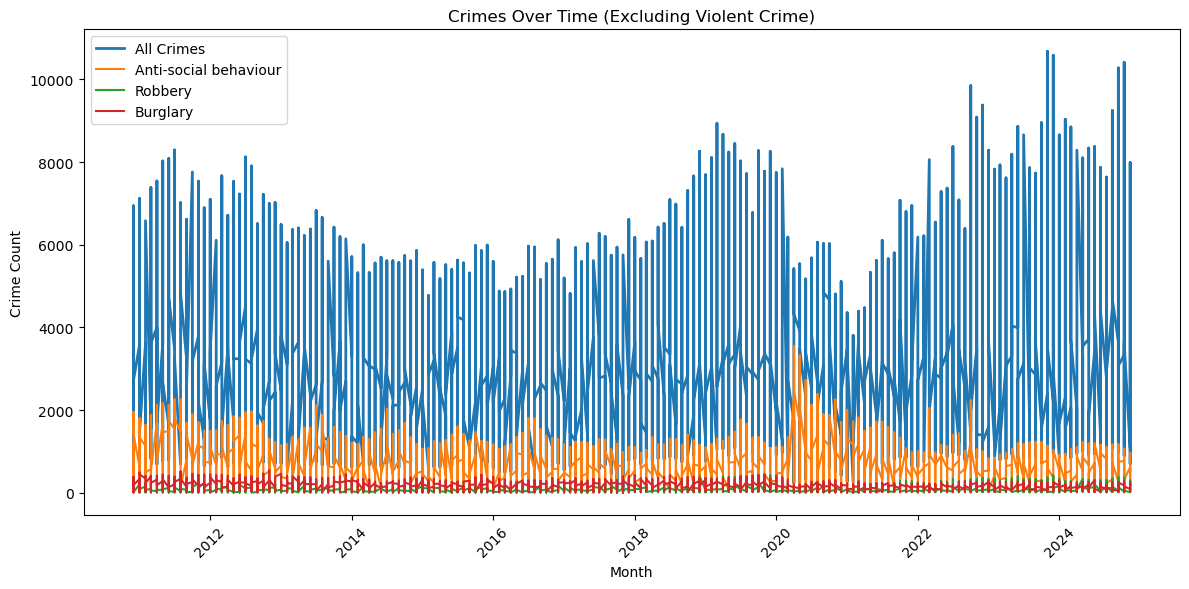

In [36]:
import matplotlib.pyplot as plt

# 1. Prepare the data, sorting by Month for each line
df_all = grouped_all_pd[['Month', 'crime_count_all']].copy()
df_all = df_all.sort_values('Month')

df_asb = grouped_type_pd['Anti-social behaviour'][['Month','crime_count']].copy()
df_asb = df_asb.sort_values('Month')

df_rob = grouped_type_pd['Robbery'][['Month','crime_count']].copy()
df_rob = df_rob.sort_values('Month')

df_bur = grouped_type_pd['Burglary'][['Month','crime_count']].copy()
df_bur = df_bur.sort_values('Month')

# 2. Create a single figure/axis
plt.figure(figsize=(12, 6))

# 3. Plot each line
plt.plot(df_all['Month'], df_all['crime_count_all'], label='All Crimes', linewidth=2)
plt.plot(df_asb['Month'], df_asb['crime_count'], label='Anti-social behaviour')
plt.plot(df_rob['Month'], df_rob['crime_count'], label='Robbery')
plt.plot(df_bur['Month'], df_bur['crime_count'], label='Burglary')

# 4. Formatting
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Crimes Over Time (Excluding Violent Crime)')
plt.legend()
plt.xticks(rotation=45)  # If months are too crowded, rotate labels
plt.tight_layout()

# 5. Show or save
plt.savefig('four_crime_lines.png', dpi=100)
plt.show()


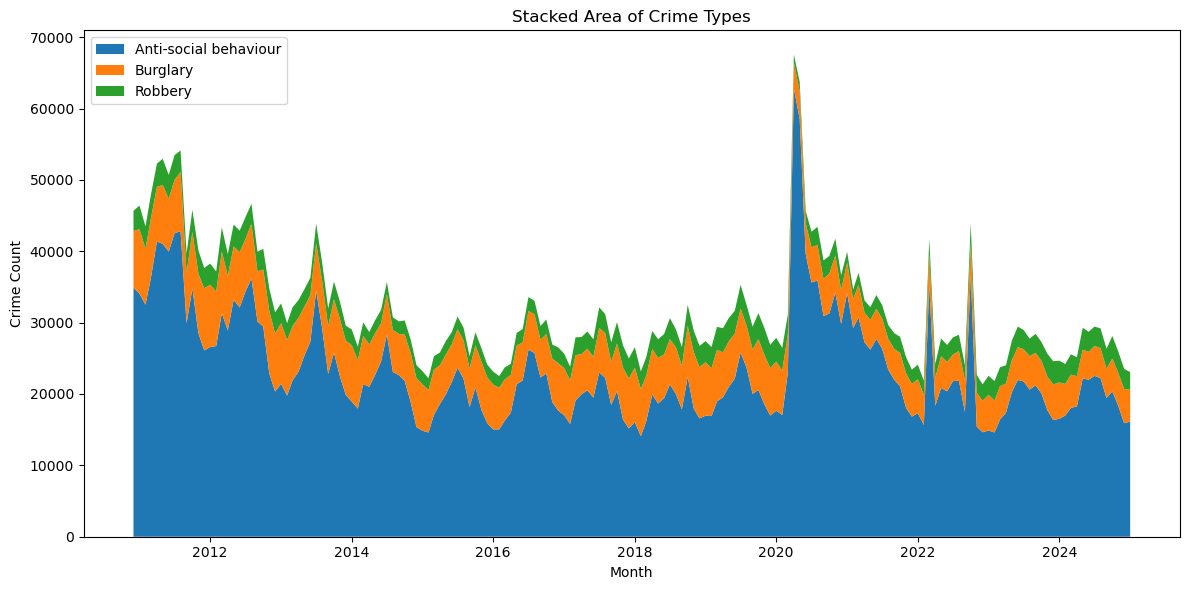

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Combine your data
#    Suppose you have the following for each category:
#    df_all -> columns ["Month", "crime_count", "Crime type" = "All Crimes"]
#    df_asb -> columns ["Month", "crime_count", "Crime type" = "Anti-social behaviour"]
#    df_rob -> columns ["Month", "crime_count", "Crime type" = "Robbery"]
#    df_bur -> columns ["Month", "crime_count", "Crime type" = "Burglary"]
# Make sure each DataFrame has the same column names and the final "Crime type" column

df_combined = pd.concat([df_asb, df_rob, df_bur], ignore_index=True)

# 2) Pivot *with* an aggregator to handle duplicates
df_pivot = df_combined.pivot_table(
    index="Month",
    columns="Crime type",
    values="crime_count",
    aggfunc="sum",
    fill_value=0
)

# 3) (Optional) Sort by Month if it's a datetime
df_pivot = df_pivot.sort_index()

# 4) Prepare for stackplot
months = df_pivot.index
crime_types = df_pivot.columns  # e.g. ["All Crimes", "Anti-social behaviour", "Robbery", "Burglary"]

# Transpose so each row is a crime type, each column is a month
values = df_pivot.values.T  # shape => (num_crime_types, num_months)

# 5) Plot stacked area
plt.figure(figsize=(12, 6))
plt.stackplot(months, values, labels=crime_types)

plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.title("Stacked Area of Crime Types")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


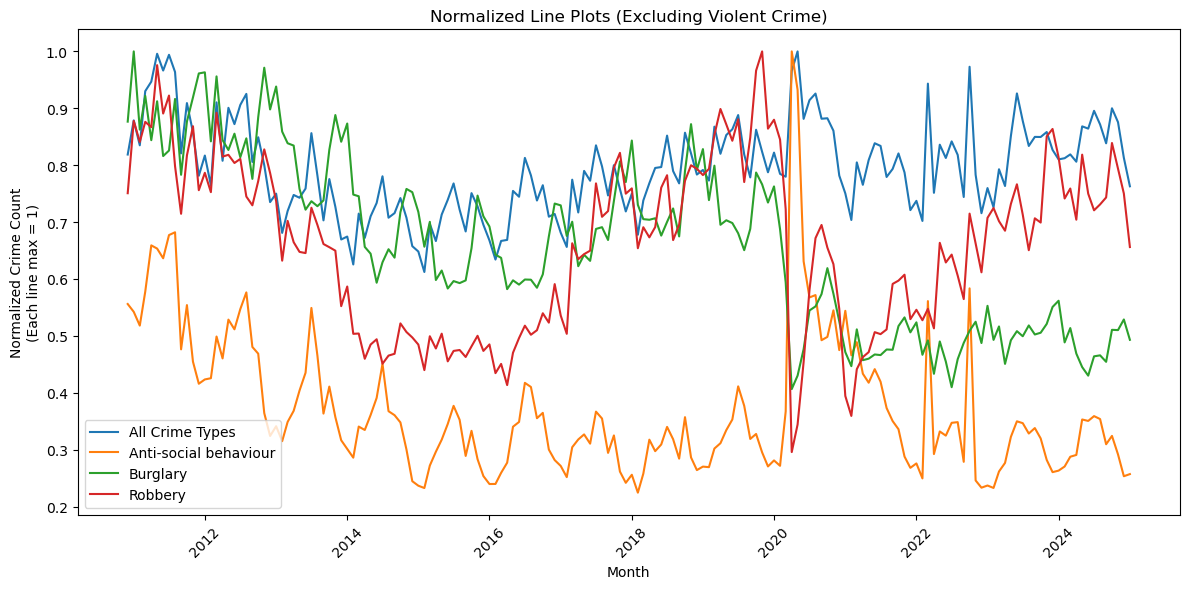

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Create a combined DataFrame for these four categories
#    (omitting "Violent crime").
#
# Suppose we have:
#    grouped_all_pd => columns ["Month", "crime_count_all"]
#    grouped_type_pd["Anti-social behaviour"] => ["Month", "crime_count"]
#    grouped_type_pd["Robbery"] => ["Month", "crime_count"]
#    grouped_type_pd["Burglary"] => ["Month", "crime_count"]

df_all = grouped_all_pd[['Month','crime_count_all']].copy()
df_all['Crime type'] = "All Crime Types"
df_all.rename(columns={'crime_count_all': 'crime_count'}, inplace=True)

df_asb = grouped_type_pd['Anti-social behaviour'][['Month','crime_count']].copy()
df_asb['Crime type'] = "Anti-social behaviour"

df_rob = grouped_type_pd['Robbery'][['Month','crime_count']].copy()
df_rob['Crime type'] = "Robbery"

df_bur = grouped_type_pd['Burglary'][['Month','crime_count']].copy()
df_bur['Crime type'] = "Burglary"

df_combined = pd.concat([df_all, df_asb, df_rob, df_bur], ignore_index=True)

# 2) Pivot *with aggregator* in case duplicates exist
df_pivot = df_combined.pivot_table(
    index='Month',
    columns='Crime type',
    values='crime_count',
    aggfunc='sum',
    fill_value=0
)

# 3) Sort by Month if it's a datetime
df_pivot = df_pivot.sort_index()

# 4) Normalize each column so its own max is 1
#    => Each line’s shape is preserved, but on a [0..1] scale.
df_norm = df_pivot.div(df_pivot.max())

# 5) Plot the lines
plt.figure(figsize=(12, 6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.xlabel("Month")
plt.ylabel("Normalized Crime Count\n(Each line max = 1)")
plt.title("Normalized Line Plots (Excluding Violent Crime)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("normalized_lines_excl_violent.png", dpi=100)
plt.show()



In [57]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/mnt/c/Users/Ruben/GPUcodig/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"


In [60]:


# Ensure the output directory exists
output_dir = "/mnt/c/Users/Ruben/Documents/Project_crime"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
gif_filename = os.path.join(output_dir, "crime_points_evolution.mp4")

# (Assuming 'frames' is your list of high-resolution PIL images)
frames_np = [np.array(frame) for frame in frames]

# Set the IMAGEIO_FFMPEG_EXE environment variable if needed:
os.environ["IMAGEIO_FFMPEG_EXE"] = "/mnt/c/Users/Ruben/GPUcodig/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"

# Write the MP4 video using FFMPEG (using the higher-level mimsave)
imageio.mimsave(gif_filename, frames_np, fps=1, format="FFMPEG", codec="libx264", quality=8)
print(f"Saved MP4 video as {gif_filename}")


[rawvideo @ 00000231fb760740] Stream #0: not enough frames to estimate rate; consider increasing probesize
[out#0/mp4 @ 00000231fb74dac0] Error opening output /mnt/c/Users/Ruben/Documents/Project_crime/crime_points_evolution.mp4: No such file or directory
Error opening output file /mnt/c/Users/Ruben/Documents/Project_crime/crime_points_evolution.mp4.
Error opening output files: No such file or directory


OSError: [Errno 32] Broken pipe

FFMPEG COMMAND:
/mnt/c/Users/Ruben/GPUcodig/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe -y -f rawvideo -vcodec rawvideo -s 3840x2160 -pix_fmt rgba -r 1.00 -i - -an -vcodec libx264 -pix_fmt yuv420p -crf 10 -v warning /mnt/c/Users/Ruben/Documents/Project_crime/crime_points_evolution.mp4

FFMPEG STDERR OUTPUT:


In [61]:
for i, frame in enumerate(frames):
    print(i, frame.size, frame.mode)


0 (3840, 2160) RGBA
1 (3840, 2160) RGBA
2 (3840, 2160) RGBA
3 (3840, 2160) RGBA
4 (3840, 2160) RGBA
5 (3840, 2160) RGBA
6 (3840, 2160) RGBA
7 (3840, 2160) RGBA
8 (3840, 2160) RGBA
9 (3840, 2160) RGBA
10 (3840, 2160) RGBA
11 (3840, 2160) RGBA
12 (3840, 2160) RGBA
13 (3840, 2160) RGBA
14 (3840, 2160) RGBA
15 (3840, 2160) RGBA
16 (3840, 2160) RGBA
17 (3840, 2160) RGBA
18 (3840, 2160) RGBA
19 (3840, 2160) RGBA
20 (3840, 2160) RGBA
21 (3840, 2160) RGBA
22 (3840, 2160) RGBA
23 (3840, 2160) RGBA
24 (3840, 2160) RGBA
25 (3840, 2160) RGBA
26 (3840, 2160) RGBA
27 (3840, 2160) RGBA
28 (3840, 2160) RGBA
29 (3840, 2160) RGBA
30 (3840, 2160) RGBA
31 (3840, 2160) RGBA
32 (3840, 2160) RGBA
33 (3840, 2160) RGBA
34 (3840, 2160) RGBA
35 (3840, 2160) RGBA
36 (3840, 2160) RGBA
37 (3840, 2160) RGBA
38 (3840, 2160) RGBA
39 (3840, 2160) RGBA
40 (3840, 2160) RGBA
41 (3840, 2160) RGBA
42 (3840, 2160) RGBA
43 (3840, 2160) RGBA
44 (3840, 2160) RGBA
45 (3840, 2160) RGBA
46 (3840, 2160) RGBA
47 (3840, 2160) RGBA
48

# Further refine crime data gpkg 

In [64]:
import sqlite3

def list_tables(db_path):
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Execute query to retrieve all table names
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        # Output the table names
        print("Tables in database:")
        for table in tables:
            print(table[0])
    except sqlite3.Error as e:
        print("Database error encountered:", e)
    finally:
        # Ensure the connection is properly closed
        if conn:
            conn.close()

def list_columns(db_path, table_name):
    try:
        # Establish connection to the SQLite database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        # Retrieve column details from the specified table using PRAGMA
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        
        # Output column details: (cid, name, type, notnull, default_value, pk)
        print(f"Columns in table '{table_name}':")
        for col in columns:
            print(f"Column: {col[1]}, Type: {col[2]}, Not Null: {col[3]}, Default: {col[4]}, Primary Key: {col[5]}")
    except sqlite3.Error as e:
        print("Database error encountered:", e)
    finally:
        if conn:
            conn.close()

# Replace 'example.db' with the path to your SQLite database file
if __name__ == "__main__":
    db_file = r'/mnt/c/Users/Ruben/Documents/Project_crime/data/crime_data_London.gpkg'
    list_tables(db_file)
    list_columns(db_file, 'crime')


Tables in database:
gpkg_spatial_ref_sys
gpkg_contents
gpkg_ogr_contents
gpkg_geometry_columns
gpkg_tile_matrix_set
gpkg_tile_matrix
sqlite_sequence
gpkg_extensions
crime
rtree_crime_geom
rtree_crime_geom_rowid
rtree_crime_geom_node
rtree_crime_geom_parent
Columns in table 'crime':
Column: fid, Type: INTEGER, Not Null: 1, Default: None, Primary Key: 1
Column: geom, Type: POINT, Not Null: 0, Default: None, Primary Key: 0
Column: Crime ID, Type: TEXT, Not Null: 0, Default: None, Primary Key: 0
Column: Month, Type: TEXT, Not Null: 0, Default: None, Primary Key: 0
Column: Reported by, Type: TEXT, Not Null: 0, Default: None, Primary Key: 0
Column: Falls within, Type: TEXT, Not Null: 0, Default: None, Primary Key: 0
Column: Longitude, Type: REAL, Not Null: 0, Default: None, Primary Key: 0
Column: Latitude, Type: REAL, Not Null: 0, Default: None, Primary Key: 0
Column: Location, Type: TEXT, Not Null: 0, Default: None, Primary Key: 0
Column: LSOA code, Type: TEXT, Not Null: 0, Default: None, P

In [ ]:
# drop columns we dont need all the data
columns_keep = set(["fid", "Month", "Crime type", "geom","geometry"])
present_columns = set(gdf.columns)
drop_columns = present_columns - columns_keep
drop_columns = list(drop_columns)
alter_table = 'crime'
drop_queries = []
for drop_column in drop_columns:
    drop_queries.append(f'ALTER TABLE {alter_table} DROP COLUMN "{drop_column}";')

# Path to your SQLite database file (update with your actual database path)
db_file = r'/mnt/c/Users/Ruben/Documents/Project_crime/data/crime_data_London.gpkg'

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    
    # Execute each DROP COLUMN query
    for drop_qry in drop_queries:
        try:
            cursor.execute(drop_qry)
            conn.commit()  # Commit after each successful execution
            print(f"Successfully executed: {drop_qry}")
        except sqlite3.Error as e:
            # Log error and continue with next query
            print(f"Error executing query: {drop_qry}\nError: {e}")
finally:
    # Always ensure the connection is closed
    if conn:
        conn.close()

['ALTER TABLE crime DROP COLUMN "Last outcome category";', 'ALTER TABLE crime DROP COLUMN "Reported by";', 'ALTER TABLE crime DROP COLUMN "LSOA code";', 'ALTER TABLE crime DROP COLUMN "Longitude";', 'ALTER TABLE crime DROP COLUMN "Falls within";', 'ALTER TABLE crime DROP COLUMN "Latitude";', 'ALTER TABLE crime DROP COLUMN "Crime ID";', 'ALTER TABLE crime DROP COLUMN "LSOA name";', 'ALTER TABLE crime DROP COLUMN "x";', 'ALTER TABLE crime DROP COLUMN "Location";', 'ALTER TABLE crime DROP COLUMN "y";', 'ALTER TABLE crime DROP COLUMN "Context";']


# Temperature data
 

In [60]:
from meteostat.interface.stations import Stations
station_data = Stations()


In [61]:
station_data._data

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
00FAY,Holden Agdm,CA,AB,71227,CXHD,53.1900,-112.2500,688.0,America/Edmonton,2020-01-01,2024-12-07,2002-11-01,2024-03-13,2003-01-01,2022-01-01
00TG6,Athabasca 1,CA,AB,<NA>,<NA>,54.7200,-113.2900,515.0,America/Edmonton,NaT,NaT,2000-01-01,2022-07-12,2000-01-01,2010-01-01
01001,Jan Mayen,NO,<NA>,01001,ENJA,70.9333,-8.6667,10.0,Europe/Oslo,1931-01-01,2025-01-07,1921-12-31,2025-03-06,1922-01-01,2022-01-01
01002,Grahuken,NO,SJ,01002,<NA>,79.7833,14.4667,0.0,Europe/Oslo,1986-11-09,2025-01-07,2010-10-07,2020-08-17,NaT,NaT
01003,Hornsund,NO,<NA>,01003,<NA>,77.0000,15.5000,10.0,Europe/Oslo,1985-06-01,2025-01-07,2009-11-26,2020-08-31,2016-01-01,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXYDC,Bonavista,CA,NL,71178,<NA>,48.6700,-53.1100,26.0,America/St_Johns,2020-01-01,2022-12-14,2006-07-09,2022-12-11,2006-01-01,2022-01-01
ZYC17,Kingston Airport,CA,ON,<NA>,<NA>,44.2300,-76.6000,92.0,America/Toronto,2020-01-01,2022-12-15,2018-10-29,2022-12-12,2019-01-01,2022-01-01
ZYITU,Selfridge Air National Guard Base,US,MI,<NA>,KMTC,42.6046,-82.8353,177.0,America/Detroit,2022-04-23,2025-03-13,2022-04-24,2022-04-25,NaT,NaT


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
vancouver = Point(49.2497, -123.1193, 70)

# Get daily data for 2018
data = Daily(vancouver, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()
